In [194]:
import pandas as pd
import numpy as np
import requests
from plotnine import *
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [186]:

with open("golf_API_key", "r") as file:
    api_key = file.read().strip()
    
base_url = "https://live-golf-data.p.rapidapi.com/leaderboard"

headers =  {
	"x-rapidapi-key": api_key,
	"x-rapidapi-host": "live-golf-data.p.rapidapi.com"
}

tournament_ids = ["519","100","026","033","014"]

In [187]:
scoreboard_list = []
for tour_id in tournament_ids:
    params = {"orgId":"1","tournId": tour_id,"year":"2024"}
    response = requests.get(base_url, headers=headers, params=params)
    data = response.json()
    for score in data['leaderboardRows']:
        rounds = score.get('rounds', [])
        first_round_score = rounds[0].get('strokes').get('$numberInt') if len(rounds) > 0 else None
        second_round_score = rounds[1].get('strokes').get('$numberInt') if len(rounds) > 1 else None
        third_round_score = rounds[2].get('strokes').get('$numberInt') if len(rounds) > 2 else None
        fourth_round_score = rounds[3].get('strokes').get('$numberInt') if len(rounds) > 3 else None
        course_name = rounds[0].get('courseName')

        score_info = {
            'Name': f"{score.get('firstName')} {score.get('lastName')}",
            'Course Name': course_name,
            'Position' : score.get('position'),
            'Strokes Under' : score.get('total'),
            'Total Strokes' : score.get('totalStrokesFromCompletedRounds'),
            'First Round': first_round_score,
            'Second Round' : second_round_score,
            'Third Round' : third_round_score,
            'Fourth Round' : fourth_round_score,
            'Fourth Round Tee Time' : score.get('teeTime'),
            'Amateur Status': score.get('isAmateur'),
            'Tournament Status' : score.get('status'),
            'ID' : score.get('playerId')
        }
        scoreboard_list.append(score_info)

scoreboard_df = pd.DataFrame(scoreboard_list)
scoreboard_df.head(5)

,Name,Course Name,Position,Strokes Under,Total Strokes,First Round,Second Round,Third Round,Fourth Round,Fourth Round Tee Time,Amateur Status,Tournament Status,ID
0,Scottie Scheffler,Le Golf National,1,-19,265,67,69,67,62,12:17pm,False,complete,46046
1,Tommy Fleetwood,Le Golf National,2,-18,266,67,64,69,66,12:39pm,False,complete,30911
2,Hideki Matsuyama,Le Golf National,3,-17,267,63,68,71,65,12:28pm,False,complete,32839
3,Victor Perez,Le Golf National,4,-16,268,70,67,68,63,11:55am,False,complete,47679
4,Rory McIlroy,Le Golf National,T5,-15,269,68,69,66,66,12:28pm,False,complete,28237


In [188]:
#filter out players that didn't finish and clean up data types
scoreboard_df = scoreboard_df[scoreboard_df['Tournament Status'] == 'complete']
scoreboard_df['Position'] = pd.to_numeric(scoreboard_df['Position'].replace(r'^T', '', regex=True), errors='coerce')
scoreboard_df['Total Strokes'] = pd.to_numeric(scoreboard_df['Total Strokes'])
scoreboard_df['First Round'] = pd.to_numeric(scoreboard_df['First Round'])
scoreboard_df['Second Round'] = pd.to_numeric(scoreboard_df['Second Round'])
scoreboard_df['Third Round'] = pd.to_numeric(scoreboard_df['Third Round'])
scoreboard_df['Fourth Round'] = pd.to_numeric(scoreboard_df['Fourth Round'])
scoreboard_df['Fourth Round Tee Time'] = scoreboard_df['Fourth Round Tee Time'].str.replace('(?i)(am|pm)', r' \1', regex=True)
scoreboard_df['Fourth Round Tee Time'] = pd.to_datetime(scoreboard_df['Fourth Round Tee Time'], format="%I:%M %p").dt.time
scoreboard_df.head()

,Name,Course Name,Position,Strokes Under,Total Strokes,First Round,Second Round,Third Round,Fourth Round,Fourth Round Tee Time,Amateur Status,Tournament Status,ID
0,Scottie Scheffler,Le Golf National,1,-19,265,67,69,67,62,12:17:00,False,complete,46046
1,Tommy Fleetwood,Le Golf National,2,-18,266,67,64,69,66,12:39:00,False,complete,30911
2,Hideki Matsuyama,Le Golf National,3,-17,267,63,68,71,65,12:28:00,False,complete,32839
3,Victor Perez,Le Golf National,4,-16,268,70,67,68,63,11:55:00,False,complete,47679
4,Rory McIlroy,Le Golf National,5,-15,269,68,69,66,66,12:28:00,False,complete,28237


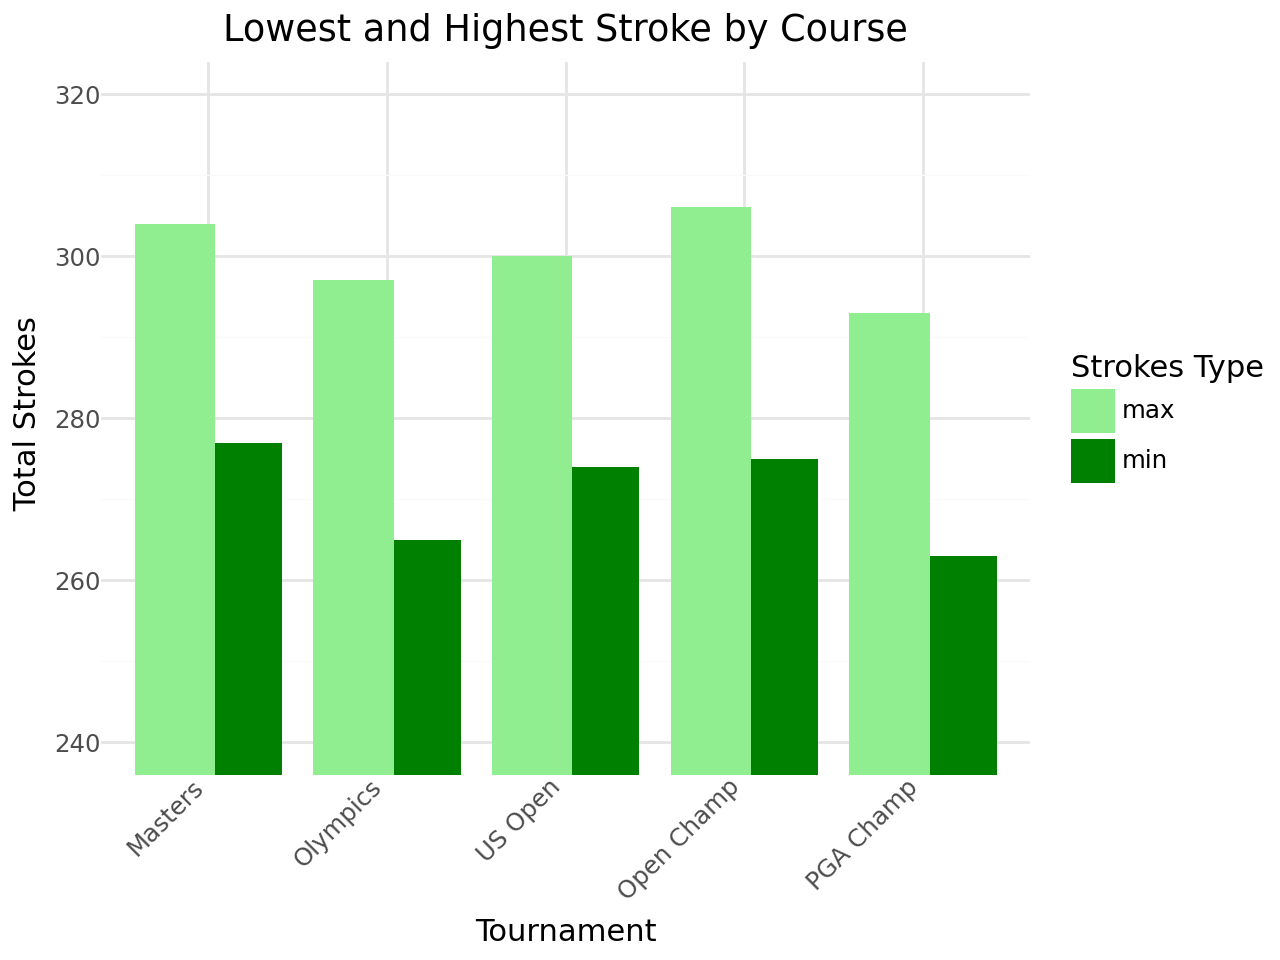

In [189]:
mm_df = scoreboard_df.groupby('Course Name')['Total Strokes'].agg(['min', 'max']).reset_index()
mm_df = mm_df.melt(id_vars='Course Name', value_vars=['min', 'max'], 
                     var_name='Strokes Type', value_name='Strokes')


(ggplot(mm_df, aes(x='Course Name', y='Strokes', fill='Strokes Type')) +
 geom_bar(stat='identity', position=position_dodge(width=0.75)) +
 labs(title="Lowest and Highest Stroke by Course", x="Tournament", y=" Total Strokes") +
 scale_fill_manual(values = {'min':'green', 'max':'lightgreen'}) + 
 scale_x_discrete(labels={'Le Golf National': 'Olympics', 'Royal Troon': 'Open Champ', 'Pinehurst Resort & Country Club (Course No. 2)': 'US Open', 'Augusta National Golf Club': 'Masters', 'Valhalla Golf Club':'PGA Champ'}) +
 coord_cartesian(ylim=(240, 320)) + 
 theme_minimal() +
 theme(
  axis_text_x=element_text(rotation=45, ha='right')
 ))


C:\Users\fellars\AppData\Local\Temp\ipykernel_3160\3003059304.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\fellars\AppData\Local\Temp\ipykernel_3160\3003059304.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




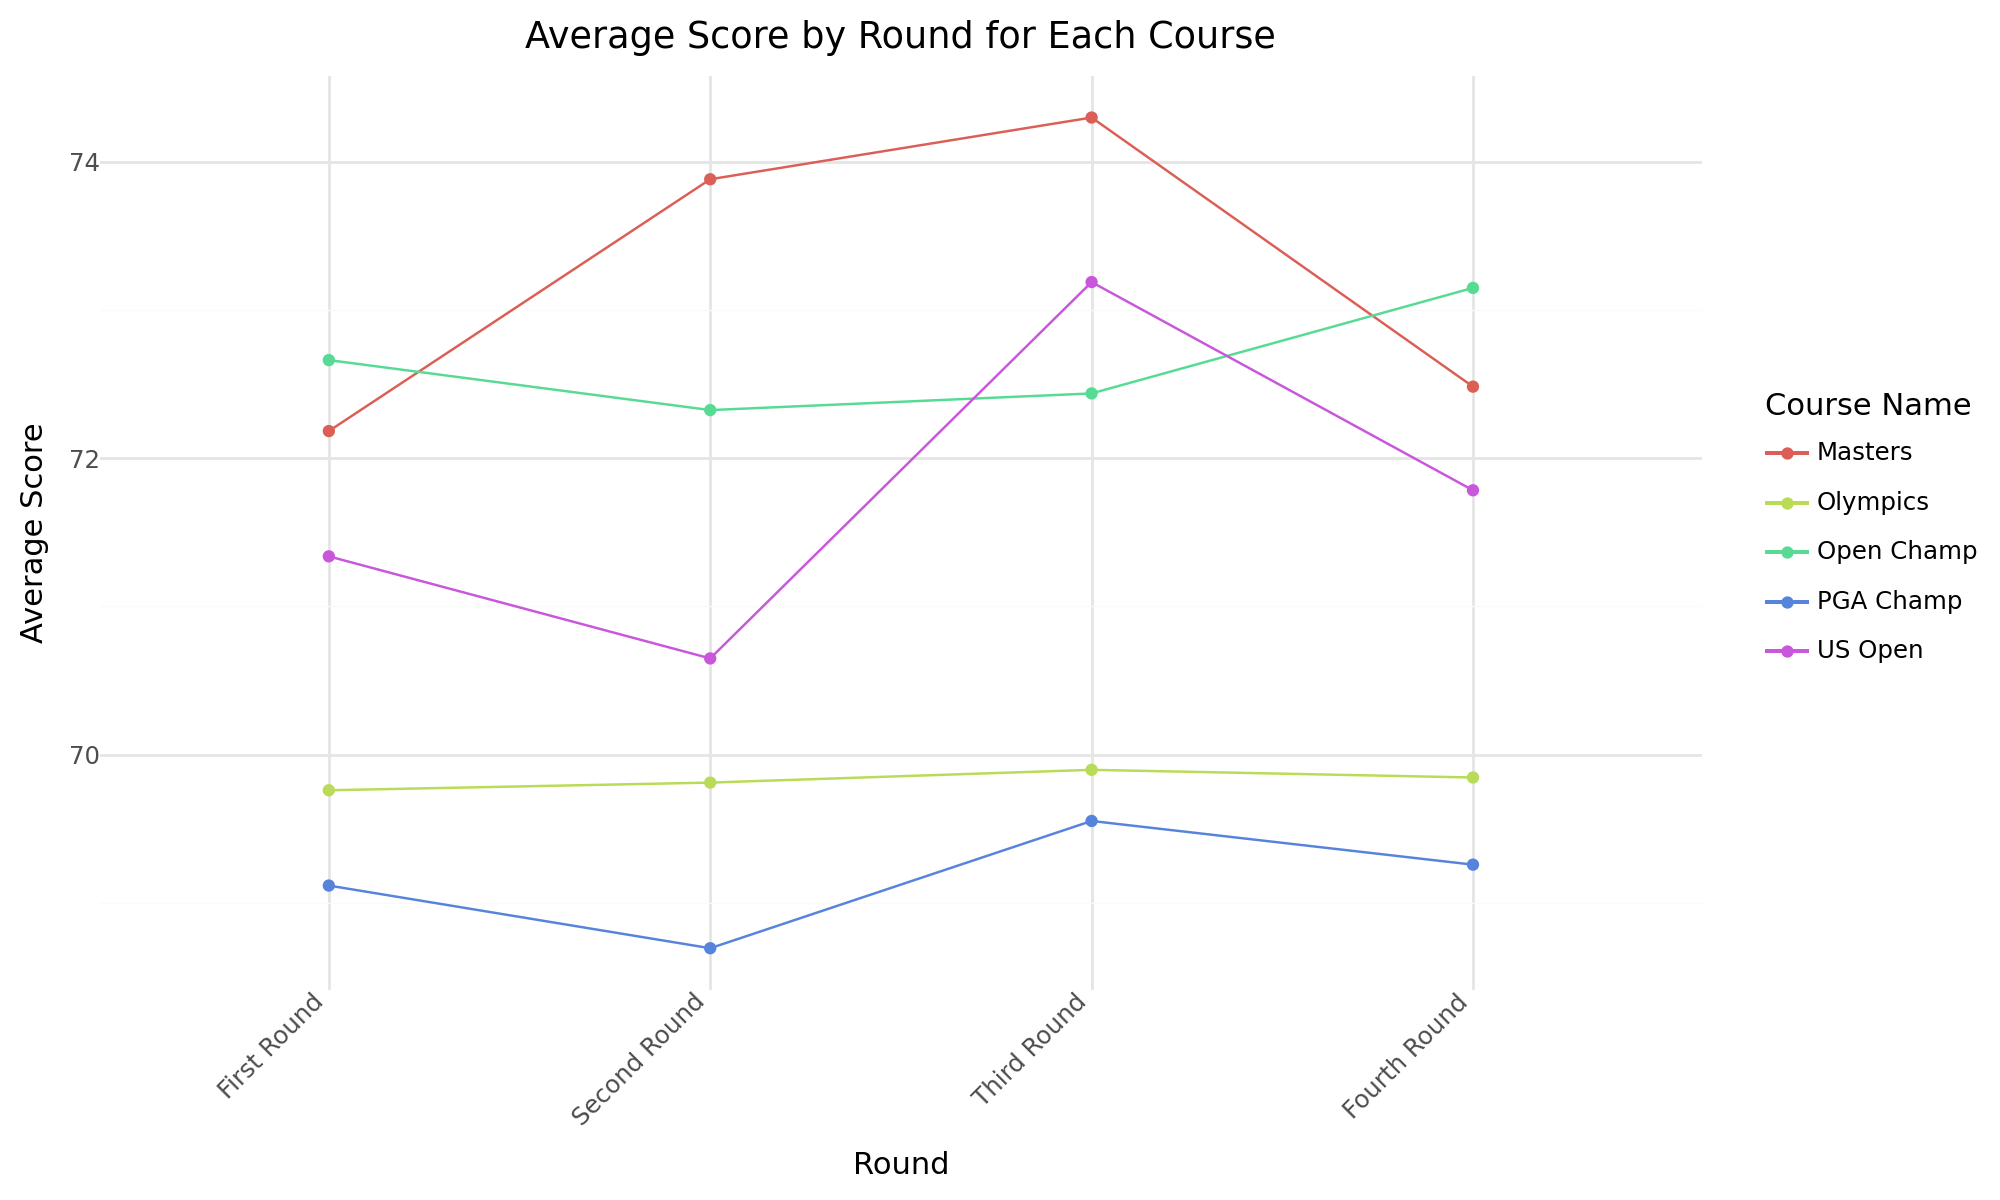

In [190]:

rounds_df = scoreboard_df.melt(id_vars=['ID', 'Course Name', 'Name'], 
                    value_vars=['First Round', 'Second Round', 'Third Round', 'Fourth Round'], 
                    var_name='Round', value_name='Score')

round_order = ['First Round', 'Second Round', 'Third Round', 'Fourth Round']
rounds_df['Round'] = pd.Categorical(rounds_df['Round'], categories=round_order, ordered=True)

avg_scores = rounds_df.groupby(['Course Name', 'Round'])['Score'].mean().reset_index()

avg_scores['Course Name'].replace({
    'Le Golf National': 'Olympics', 
    'Royal Troon': 'Open Champ', 
    'Pinehurst Resort & Country Club (Course No. 2)': 'US Open', 
    'Augusta National Golf Club': 'Masters', 
    'Valhalla Golf Club': 'PGA Champ'
}, inplace=True)

(ggplot(avg_scores, aes(x='Round', y='Score', color='Course Name', group='Course Name')) +
 geom_line() +
 geom_point() +
 labs(title="Average Score by Round for Each Course", x="Round", y="Average Score") +
 theme_minimal() +
 theme(
     figure_size=(10, 6),  # Increase figure size
     axis_text_x=element_text(rotation=45, ha='right')
 ))

C:\Users\fellars\AppData\Local\Temp\ipykernel_3160\795123528.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




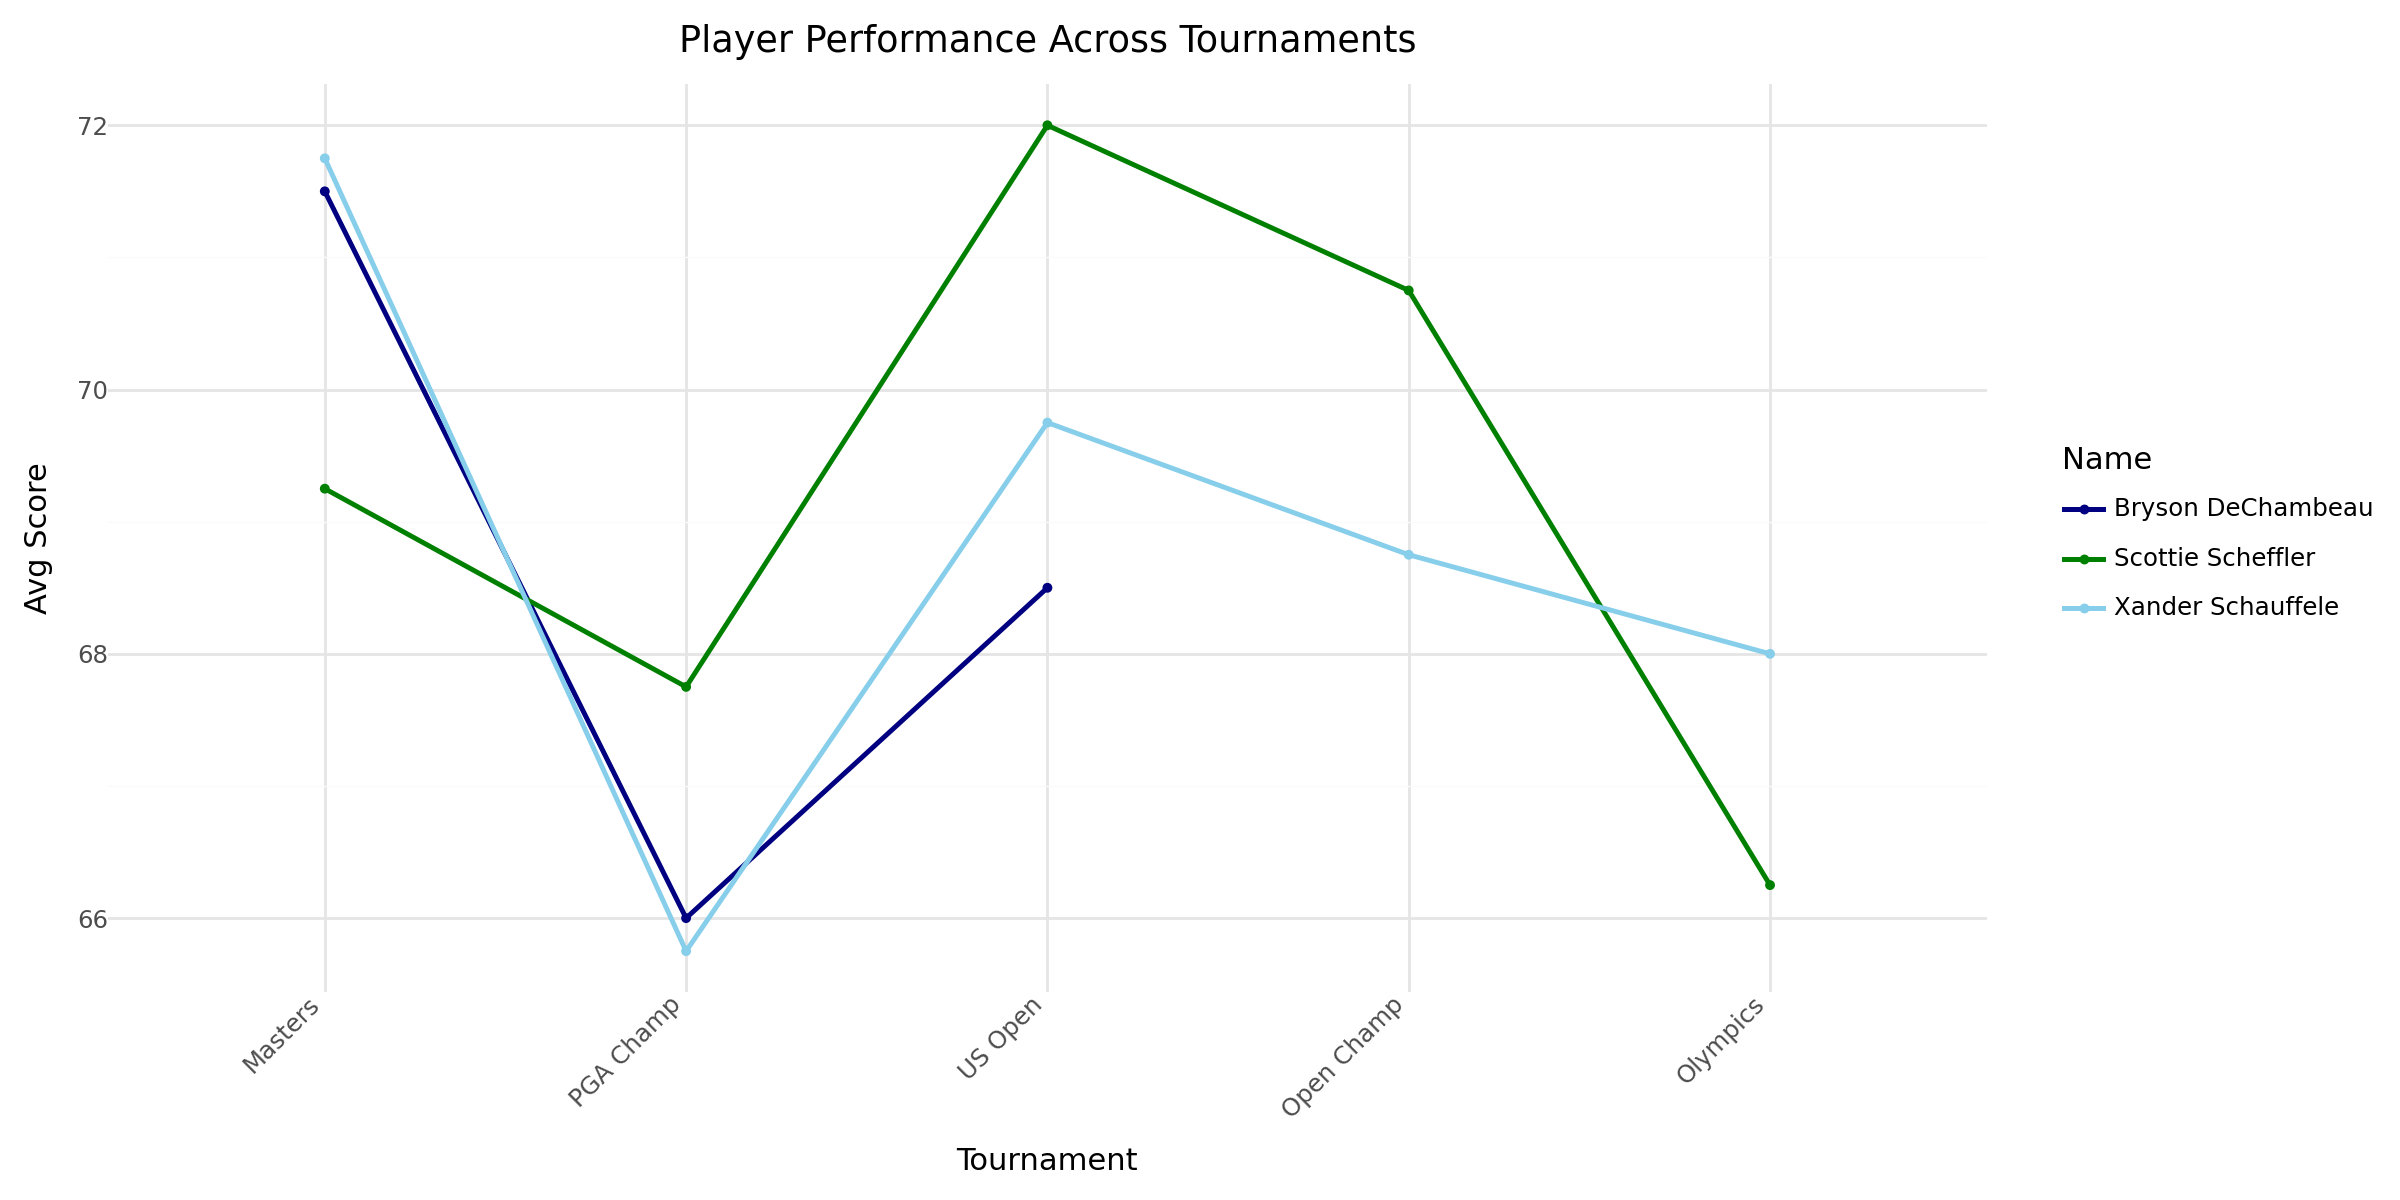

In [191]:
top_players = scoreboard_df[scoreboard_df['Position'] == 1]
player_data = rounds_df[rounds_df['ID'].isin(top_players['ID'])]
avg_scores = player_data.groupby(['ID', 'Course Name', 'Name'])['Score'].mean().reset_index()

avg_scores['Course Name'].replace({
    'Le Golf National': 'Olympics', 
    'Royal Troon': 'Open Champ', 
    'Pinehurst Resort & Country Club (Course No. 2)': 'US Open', 
    'Augusta National Golf Club': 'Masters', 
    'Valhalla Golf Club': 'PGA Champ'
}, inplace=True)

course_order = ['Masters', 'PGA Champ', 'US Open', 'Open Champ', 'Olympics']
avg_scores['Course Name'] = pd.Categorical(avg_scores['Course Name'], categories=course_order, ordered=True)

(ggplot(avg_scores, aes(x='Course Name', y='Score', color='Name', group='Name')) +
 geom_line(size = 1) +
 geom_point(size =1) +
 labs(title="Player Performance Across Tournaments", x="Tournament", y="Avg Score") +
 scale_color_manual(values= {'Bryson DeChambeau': 'navy', 'Scottie Scheffler': 'green', 'Xander Schauffele': 'skyblue'}) +
 theme_minimal() +
 theme(
     figure_size=(12, 6),
     axis_text_x=element_text(rotation=45, ha='right')
 ))


In [199]:

numeric_df = scoreboard_df.select_dtypes(include=['number'])
numeric_df['Date_numeric'] = scoreboard_df['Fourth Round Tee Time'].astype('int64') // 10**9
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'datetime.time'

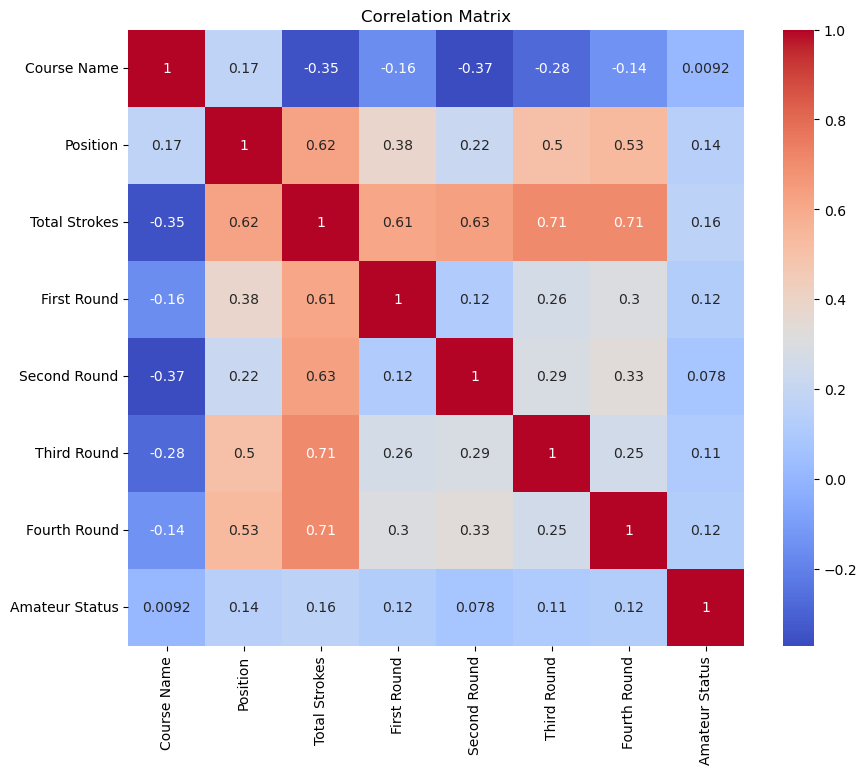

In [209]:
scoreboard_df.dtypes
corr_df = scoreboard_df
corr_df['Course Name'] = corr_df['Course Name'].astype('category').cat.codes
corr_df['Amateur Status'] = corr_df['Amateur Status'].astype('category').cat.codes
corr_df[['Position', 'Amateur Status']].corr()

numeric_df = corr_df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

In [206]:
scoreboard_df.dtypes


Name                     object
Course Name                int8
Position                  int64
Strokes Under            object
Total Strokes             int64
First Round               int64
Second Round              int64
Third Round               int64
Fourth Round              int64
Fourth Round Tee Time    object
Amateur Status             bool
Tournament Status        object
ID                       object
dtype: object